In [1]:
from vierlinden.config import model_output_path
from vierlinden.data.loader import VierlindenDataProcessor
from vierlinden.model.model import NHiTSTrainingWrapper, NHiTSPredictionWrapper

seed = 42

context_length = 50
prediction_length = 10
batch_size = 32
num_workers = 18

def main(arg : str):
    dp = VierlindenDataProcessor()
    df = dp.load_processed_data()
    df = dp.prepare_for_target(df, arg)
    
    training_df, test_df = dp.split_data(df)
    
    nhits_wrapper = NHiTSTrainingWrapper(training_df, 
                                         target_col = arg, 
                                         context_length = context_length, 
                                         prediction_length = prediction_length,
                                         batch_size = batch_size, 
                                         num_workers = num_workers)
    optimal_lr = nhits_wrapper.find_optimal_learningrate(seed = seed)
    
    print(f"Optimal learning rate for {arg}: {optimal_lr}")
    
    best_model = nhits_wrapper.train(optimal_lr, seed = seed, max_epochs=2)
    
    return nhits_wrapper, test_df

/storage/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


INFO:vierlinden.data.loader:Data loaded successfully from /storage/projects/RIWWER/data/Vierlinden
INFO:vierlinden.data.loader:Sensor and target data merged successfully.
INFO:vierlinden.data.loader:NaN values processed successfully.
INFO:vierlinden.data.loader:Data loaded and processed successfully.


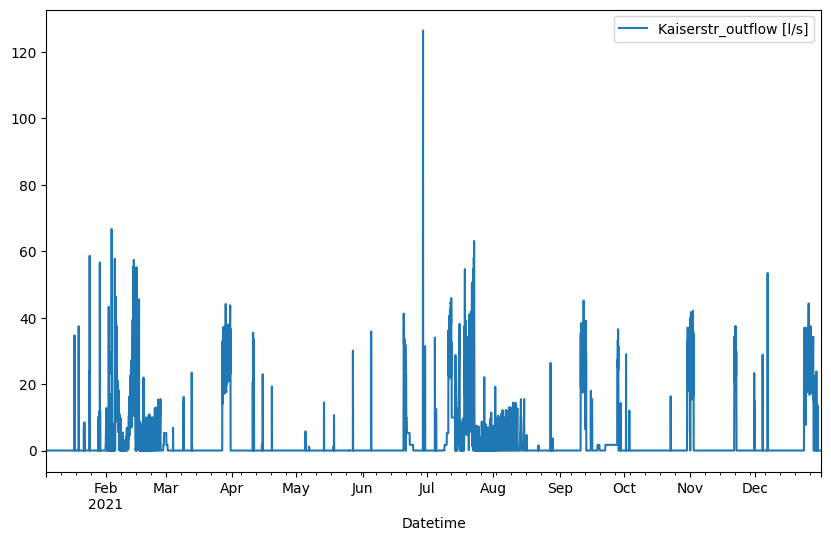

In [13]:
dp = VierlindenDataProcessor()
df = dp.load_processed_data()
df = dp.prepare_for_target(df, 'Kaiserstr_outflow [l/s]')
dp.plot_target_col('Kaiserstr_outflow [l/s]')

In [ ]:
nhits_wrapper, test_df = main('Kaiserstr_outflow [l/s]')

In [5]:
dp = VierlindenDataProcessor()
df = dp.load_processed_data()
df = dp.prepare_for_target(df, 'Kaiserstr_outflow [l/s]')

training_df, test_df = VierlindenDataProcessor.split_data(df, train_frac=0.9)
test_df.shape

INFO:vierlinden.data.loader:Data loaded successfully from /storage/projects/RIWWER/data/Vierlinden
INFO:vierlinden.data.loader:Sensor and target data merged successfully.
INFO:vierlinden.data.loader:NaN values processed successfully.
INFO:vierlinden.data.loader:Data loaded and processed successfully.


(868, 24)

In [ ]:
model = nhits_wrapper.best_model

In [6]:
model = NHiTSTrainingWrapper.load_trained_model(model_output_path + "/"  + 'test.pt')

In [7]:
from vierlinden.model.model import NHiTSPredictionWrapper
prediction_wrapper = NHiTSPredictionWrapper(model, context_length=context_length, prediction_length=prediction_length, target_col='Kaiserstr_outflow [l/s]')
something = prediction_wrapper.predict(VierlindenDataProcessor.split_data(test_df, train_frac=0.8)[1])

/storage/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


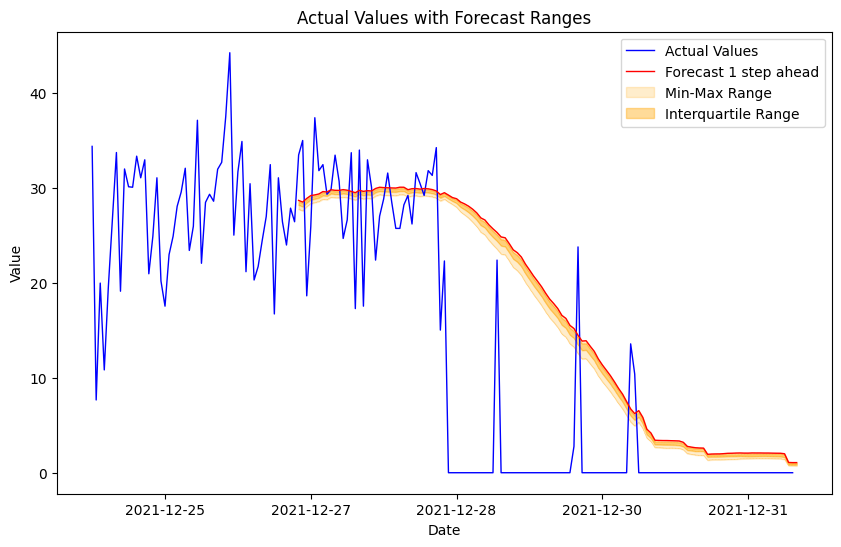

In [ ]:
prediction_wrapper.plot_forecast_for_all(forecast_step_ahead=1, plot_forecast_distribution=True)

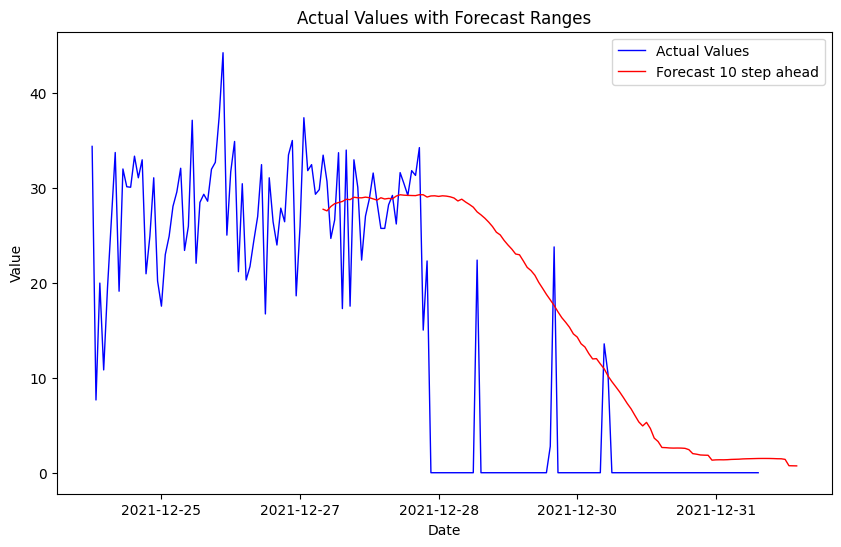

In [8]:
prediction_wrapper.plot_forecast_for_all(forecast_step_ahead=10, plot_forecast_distribution=False)

In [8]:
prediction_wrapper.get_average_mae_loss()

AttributeError: 'Prediction' object has no attribute 'loss'

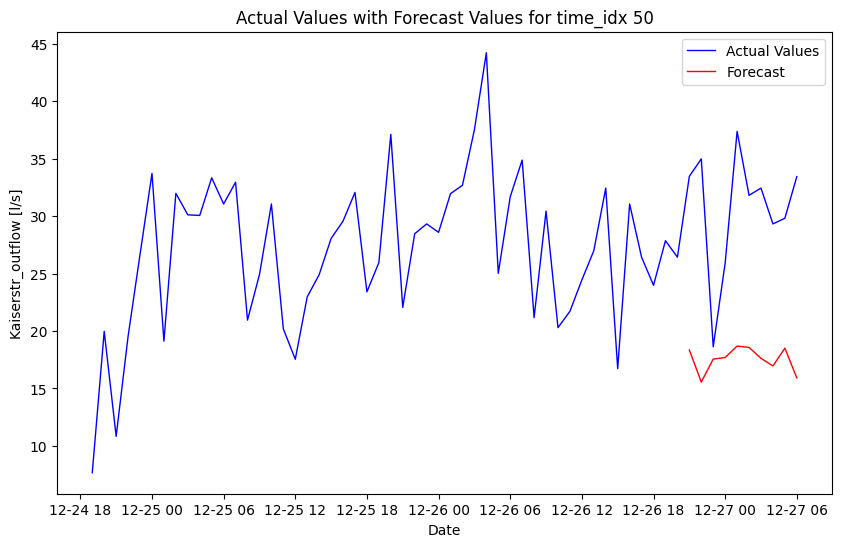

In [7]:
prediction_wrapper.plot_forecast_per_time_idx(50)

In [15]:
for time_idx in range(0, 817, 60):
    fig = model.plot_prediction(something.x, something.output, idx=time_idx, add_loss_to_title=True)

AttributeError: 'DataFrame' object has no attribute 'x'

In [16]:
print(nhits_wrapper.metrics_callback.metrics["train_loss"])
print(nhits_wrapper.metrics_callback.metrics["val_loss"])

nhits_wrapper.plot_training_result()

NameError: name 'nhits_wrapper' is not defined

In [ ]:
nhits_wrapper.save_trained_model(model_output_path + "/"  + 'test.pt')

In [ ]:
model = NHiTSTrainingWrapper.load_trained_model(model_output_path + "/"  + 'NHiTS_Kaiserstr_model.pt')

In [17]:
print(model)

NHiTS(
  	"activation":                        ReLU
  	"backcast_loss_ratio":               1.0
  	"batch_normalization":               False
  	"categorical_groups":                {}
  	"context_length":                    50
  	"downsample_frequencies":            [8, 2, 1]
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       512
  	"initialization":                    lecun_normal
  	"interpolation_mode":                linear
  	"learning_rate":                     5.623413251903491e-05
  	"log_gradient_flow":                 False
  	"log_interval":                      5
  	"log_val_interval":                  1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              MASE()
  	"monotone_constaints"